### This notebook implements the controller covered in Section 4 of [1] for the control of tropospheric CO2 covered in [2]. Here, we consider the case of C = I_n, i.e., the case of full-state feedback. The Python library for control systems used here is [3].

### References:
[1] Nersesov, S.G., Haddad, W.M. and Chellaboina, V., 2004. Optimal fixed‐structure control for linear non‐negative dynamical systems. International Journal of Robust and Nonlinear Control: IFAC‐Affiliated Journal, 14(5), pp.487-511.

[2] Zocco, F., Haddad, W.M. and Malvezzi, M., 2025. CarboNet: A finite-time combustion-tolerant compartmental network for tropospheric carbon control. arXiv preprint arXiv:2508.16774.

[3] Python control-systems library: https://python-control.readthedocs.io/en/latest/intro.html

In [1]:
%pip install control

import control as ct
import numpy as np

import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.3/578.3 kB 7.6 MB/s eta 0:00:00


In [2]:
### Create the matrix A with rate constants specified in [2] and satisfing the set-point condition 0 = Ax_e + Bv_e:

n_q = 5000 #number of vehicles
n_h = 10000 #number of houses

a_41 = 0.2
a_12 = 0.5/n_q
a_13 = 0.5/n_h
a_14 = 0.1
a_42 = 0.5/n_q
a_22 = 0.3
a_43 = 0.5/n_h
a_33 = 0.6

# Constraints from the set-point condition (0 = Ax_e + Bv_e):
if a_22 == n_q*(a_12 + a_42) or a_33 == n_h*(a_13 + a_43):
  print("Careful, pair (A, B) may not be stabilizable with these rates.")


A = np.array([[-a_41, n_q*a_12, n_h*a_13, a_14],
              [0, -n_q*(a_12+a_42)+a_22, 0, 0],
              [0, 0, -n_h*(a_13+a_43)+a_33, 0],
              [a_41, n_q*a_42, n_h*a_43, -a_14]])

B = np.array([[-1],
              [0],
              [0],
              [0]])


C = np.identity(4)

D = np.zeros((4,1))

sys = ct.ss(A, B, C, D) #create LTI system

print("A = ", A)
print("B = ", B)
print("C = ", C)
print("D = ", D)

A =  [[-0.2  0.5  0.5  0.1]
 [ 0.  -0.7  0.   0. ]
 [ 0.   0.  -0.4  0. ]
 [ 0.2  0.5  0.5 -0.1]]
B =  [[-1]
 [ 0]
 [ 0]
 [ 0]]
C =  [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
D =  [[0.]
 [0.]
 [0.]
 [0.]]


In [3]:
eigenvalues, _ = np.linalg.eig(A)
print("Eigenvalues of A:", eigenvalues)

Eigenvalues of A: [-0.3  0.  -0.7 -0.4]


Now check the conditions required by the controller of Nersesov et al. [1], Section 4. IMPORTANT: This code assumes that A has 1 eigenvalue equal to 0 and the other eigenvalues have negative real parts.

In [4]:
# (1) (A, B) must be stabilizable
# (checked with the PBH rank test: rank[\sigma*I-A   B] = n  for all eigenvalues of A, namely, \sigma, such that Re(\sigma) >= 0)

PBHmatrixTest = np.c_[-A, B]
n, _ = A.shape
if np.linalg.matrix_rank(PBHmatrixTest) == n:
    print("The pair (A, B) is stabilizable")

The pair (A, B) is stabilizable


In [5]:
# (2) There exists v_e such that 0 = Ax_e + Bv_e:

x1e = 637.2 #as indicated in the source paper [2], which correspond to the CO2 mass in the pre-industrial era
v_e = 0 #see source paper [2] for the reason of this condition
x2e = 0 #see source paper [2] for the reason of this condition
x3e = 0 #see source paper [2] for the reason of this condition
x4e = (a_41/a_14)*x1e
xe = np.array([[x1e],
               [x2e],
               [x3e],
               [x4e]])

In [6]:
# (3) (A, R_1) is observable      NOTE: R_1 is a control design matrix (i.e., it is chosen)
R_1 = np.identity(n)
Obs_matrix = ct.obsv(A, R_1)
if np.linalg.matrix_rank(Obs_matrix) == n:
    print("The pair (A, R_1) is observable")

The pair (A, R_1) is observable


In [7]:
# (4) Solve the algebraic Riccati equation in (30):
R_2 = 1  #NOTE: R_2 is a control design matrix (i.e., it is chosen)
P,_,_ = ct.care(A, B, R_1, R_2)

In [8]:
K = ((R_2)**-1)*np.matmul(np.transpose(B), P) #optimal feedback gain, i.e., equation (31) of Nersesov et al.. This is step (5)
print("K =", K)

K = [[-0.93984418 -0.66695025 -0.92842023 -0.6481119 ]]


Now simulate the response of the closed loop to initial conditions.

In [9]:
## Choose the inital conditions:
x01 = 915.4 #as indicated in the source paper [2]
x02 = 210.0 #as indicated in the source paper [2]
x03 = 500.0 #as indicated in the source paper [2]
x04 = 1830.8 #as indicated in the source paper [2]
x0 = np.array([[x01],
              [x02],
              [x03],
              [x04]])

x0 = [[ 915.4]
 [ 210. ]
 [ 500. ]
 [1830.8]]
x_tilde_0 = [[278.2]
 [210. ]
 [500. ]
 [556.4]]
A_tilde = [[-1.13984418 -0.16695025 -0.42842023 -0.5481119 ]
 [ 0.         -0.7         0.          0.        ]
 [ 0.          0.         -0.4         0.        ]
 [ 0.2         0.5         0.5        -0.1       ]]


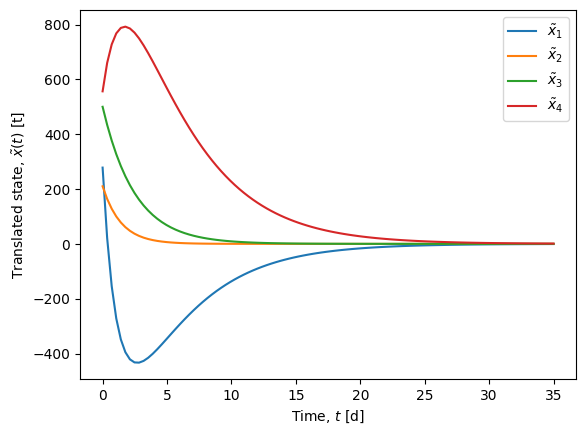

In [10]:
# Set the translated initial conditions (this is step (6)):
x_tilde_01 = x01 - x1e  # translated state because the control library used here expects a system of the form x_dot = Ax, whereas equation (32) of Nersesov et al. is of the form x_dot = A(x - x_e)
x_tilde_02 = x02 - x2e
x_tilde_03 = x03 - x3e
x_tilde_04 = x04 - x4e

x_tilde_0 = np.array([[x_tilde_01],
              [x_tilde_02],
              [x_tilde_03],
              [x_tilde_04]])

print("x0 =", x0)
print("x_tilde_0 =", x_tilde_0)

# Control law:
S = ((R_2)**-1)*np.matmul(B, np.transpose(B)) #R_2 is 1x1 in this case because m = 1 (1 control input)
A_tilde = A - np.matmul(S, P) #from equation (32) of Nersesov et al. (v = I in the case of C = I_n).    NOTE: P is the solution of the algebraic Riccati equation
sys_closedLoop = ct.ss(A_tilde, np.zeros(B.shape), C, np.zeros(D.shape)) #create LTI system of closed loop, i.e., equation (32) of Nersesov et al.
print("A_tilde =", A_tilde) #A_hat in [2]

# Simulate response of closed loop to initial conditions with translated states (this is step (7)):
SimulationTime = 35
TimeResponseData = ct.initial_response(sys_closedLoop, SimulationTime, x_tilde_0, return_x=True) # documentation: https://python-control.readthedocs.io/en/latest/generated/control.initial_response.html
plt.plot(TimeResponseData.time, TimeResponseData.states.T) # covergence to origin corresponds to convergence to x_e because x_tilde(t) = x(t) - x_e
plt.xlabel(r'Time, $t$ [d]')
plt.ylabel(r'Translated state, $\tilde{x}(t)$ [t]')
plt.legend([r'$\tilde{x}_1$', r'$\tilde{x}_2$', r'$\tilde{x}_3$', r'$\tilde{x}_4$'])

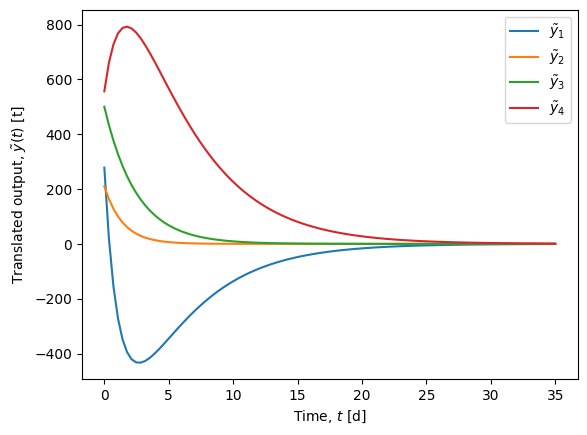

In [11]:
# Plot y_tilde(t) = C*x_tilde(t), which must result equal to x_tilde(t) because C = I_n:

plt.plot(TimeResponseData.time, TimeResponseData.outputs.T)
plt.xlabel(r'Time, $t$ [d]')
plt.ylabel(r'Translated output, $\tilde{y}(t)$ [t]')
plt.legend([r'$\tilde{y}_1$', r'$\tilde{y}_2$', r'$\tilde{y}_3$', r'$\tilde{y}_4$'])

x0 = [[ 915.4]
 [ 210. ]
 [ 500. ]
 [1830.8]]
xe = [[ 637.2]
 [   0. ]
 [   0. ]
 [1274.4]]


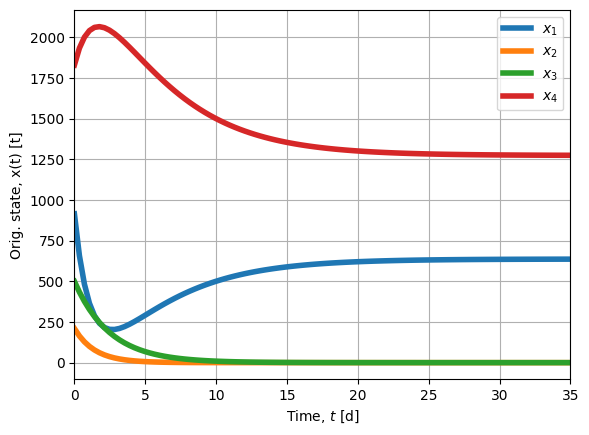

In [12]:
# Recover and plot the original states, i.e., not translated (this is step (8)):
x_tilde = TimeResponseData.states

x1 = x_tilde[0] + x1e
x2 = x_tilde[1] + x2e
x3 = x_tilde[2] + x3e
x4 = x_tilde[3] + x4e
plt.plot(TimeResponseData.time, x1, linewidth=4)
plt.plot(TimeResponseData.time, x2, linewidth=4)
plt.plot(TimeResponseData.time, x3, linewidth=4)
plt.plot(TimeResponseData.time, x4, linewidth=4)
plt.xlabel(r'Time, $t$ [d]')
plt.ylabel('Orig. state, x(t) [t]')
plt.xlim(0, 35)
plt.xticks(np.arange(0, 36, step=5))
plt.yticks(np.arange(0, 2100, step=250))
plt.legend([r'$x_1$', '$x_2$', '$x_3$', '$x_4$'], loc='upper right')
plt.grid()

print("x0 =", x0) # original initial conditions
print("xe =", xe)

/tmp/ipython-input-494611122.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u[i] = sample_u


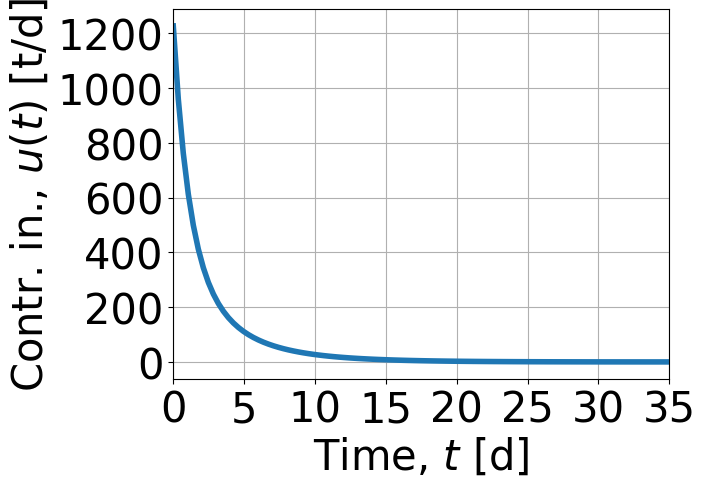

In [17]:
# Plot u(t) = -K*(y - C*x_e) + v_e (this is step (9)):
u = -1000*np.ones(len(TimeResponseData.time))
mat1 = np.matmul(C, xe)

for i in range(len(TimeResponseData.time)):
  # the library returns y_tilde = C*x_tilde, so you need to calculate y = C*x:
  x1_tilde_i = TimeResponseData.states[0,i]
  x2_tilde_i = TimeResponseData.states[1,i]
  x3_tilde_i = TimeResponseData.states[2,i]
  x4_tilde_i = TimeResponseData.states[3,i]
  x_tilde_i = np.array([[x1_tilde_i],
                 [x2_tilde_i],
                 [x3_tilde_i],
                 [x4_tilde_i]])
  yi = np.matmul(C, x_tilde_i + xe)
  mat2 = yi - mat1
  mat3 = np.matmul(K, mat2)
  sample_u = -mat3 + v_e
  u[i] = sample_u

plt.plot(TimeResponseData.time, u, linewidth=4)
plt.xlabel(r'Time, $t$ [d]')
plt.ylabel(r'Contr. in., $u(t)$ [t/d]')
plt.xlim(0, 35)
plt.xticks(np.arange(0, 36, step=5))
plt.yticks(np.arange(0, 1300, step=200))
plt.grid()

Equilibrium value of x1: 636.5784900310964
Equilibrium value of x4: 1275.4439486743186
$\gamma$: 1912.022438705415


<>:14: SyntaxWarning: invalid escape sequence '\p'
<>:14: SyntaxWarning: invalid escape sequence '\p'
<>:20: SyntaxWarning: invalid escape sequence '\g'
<>:14: SyntaxWarning: invalid escape sequence '\p'
<>:14: SyntaxWarning: invalid escape sequence '\p'
<>:20: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-1655319126.py:14: SyntaxWarning: invalid escape sequence '\p'
  plt.legend([r'$\lambda$', '$\phi_1$', '$\phi_{nz}$'], loc='lower right')
/tmp/ipython-input-1655319126.py:14: SyntaxWarning: invalid escape sequence '\p'
  plt.legend([r'$\lambda$', '$\phi_1$', '$\phi_{nz}$'], loc='lower right')
/tmp/ipython-input-1655319126.py:20: SyntaxWarning: invalid escape sequence '\g'
  print('$\gamma$:', x1[-1] + x4[-1])


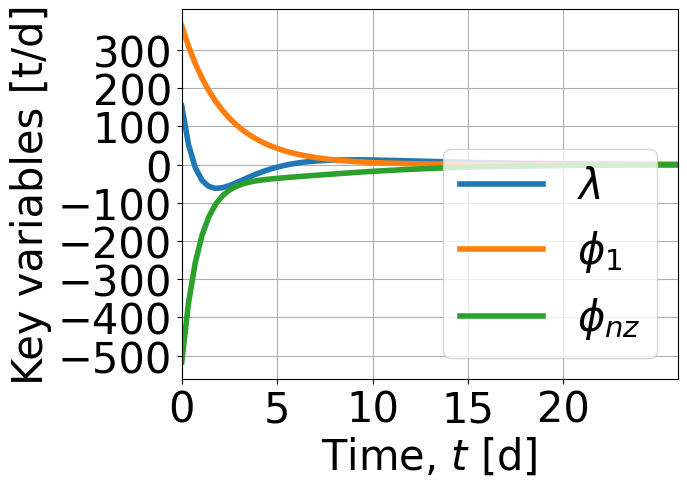

In [18]:
# Plot \lambda(t), \phi_1(t), and \phi_nz(t):
phi_nz = n_q*a_12*x2 + n_q*a_42*x2 + n_h*a_13*x3 + n_h*a_43*x3 - u #tonne/day
phi_1 = a_22*x2 + a_33*x3 #tonne/day
lambda_ = -(phi_1 + phi_nz)

plt.plot(TimeResponseData.time, lambda_, linewidth=4)
plt.plot(TimeResponseData.time, phi_1, linewidth=4)
plt.plot(TimeResponseData.time, phi_nz, linewidth=4)
plt.xlabel(r'Time, $t$ [d]')
plt.ylabel('Key variables [t/d]')
plt.xticks(np.arange(0, 25, step=5))
plt.xlim(0, 26)
plt.yticks(np.arange(-500, 400, step=100))
plt.legend([r'$\lambda$', '$\phi_1$', '$\phi_{nz}$'], loc='lower right')
plt.rcParams.update({'font.size': 30})
plt.grid()

print('Equilibrium value of x1:', x1[-1])
print('Equilibrium value of x4:', x4[-1])
print('$\gamma$:', x1[-1] + x4[-1])